# Install Libraries

In [1]:
%%time

!pip install -U -q keras-nlp
!pip install -U -q keras>=3

CPU times: user 292 ms, sys: 56 ms, total: 348 ms
Wall time: 26.1 s


# Load Files

In [2]:
%%time

import keras
import keras_nlp
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras_nlp.tokenizers import BertTokenizer

warnings.filterwarnings('ignore')

CPU times: user 8.47 s, sys: 1.22 s, total: 9.69 s
Wall time: 16 s


In [3]:
%%time

train = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')

CPU times: user 16.3 ms, sys: 4.21 ms, total: 20.5 ms
Wall time: 30.9 ms


# Check & Fill Missing Values

In [4]:
%%time

# Check for missing values
missing_values = train.isnull().sum()

missing_values

CPU times: user 6.39 ms, sys: 1.06 ms, total: 7.46 ms
Wall time: 8.69 ms


study_id                                    0
spinal_canal_stenosis_l1_l2                 1
spinal_canal_stenosis_l2_l3                 1
spinal_canal_stenosis_l3_l4                 1
spinal_canal_stenosis_l4_l5                 1
spinal_canal_stenosis_l5_s1                 1
left_neural_foraminal_narrowing_l1_l2       2
left_neural_foraminal_narrowing_l2_l3       2
left_neural_foraminal_narrowing_l3_l4       2
left_neural_foraminal_narrowing_l4_l5       2
left_neural_foraminal_narrowing_l5_s1       2
right_neural_foraminal_narrowing_l1_l2      8
right_neural_foraminal_narrowing_l2_l3      8
right_neural_foraminal_narrowing_l3_l4      8
right_neural_foraminal_narrowing_l4_l5      8
right_neural_foraminal_narrowing_l5_s1      8
left_subarticular_stenosis_l1_l2          164
left_subarticular_stenosis_l2_l3           82
left_subarticular_stenosis_l3_l4            3
left_subarticular_stenosis_l4_l5            3
left_subarticular_stenosis_l5_s1           11
right_subarticular_stenosis_l1_l2 

In [5]:
%%time

# Fill missing values
train = train.fillna(0)

train

CPU times: user 8.21 ms, sys: 1.76 ms, total: 9.97 ms
Wall time: 8.96 ms


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


# Define features and labels

In [6]:
%%time

# Select features 
features = train.drop(columns=['study_id', 
                                   'spinal_canal_stenosis_l1_l2',
                                   'spinal_canal_stenosis_l2_l3',
                                   'spinal_canal_stenosis_l3_l4',
                                   'spinal_canal_stenosis_l4_l5',
                                   'spinal_canal_stenosis_l5_s1',
                                   'left_neural_foraminal_narrowing_l1_l2',
                                   'left_neural_foraminal_narrowing_l2_l3',
                                   'left_neural_foraminal_narrowing_l3_l4',
                                   'left_neural_foraminal_narrowing_l4_l5',
                                   'left_neural_foraminal_narrowing_l5_s1',
                                   'right_neural_foraminal_narrowing_l1_l2',
                                   'right_neural_foraminal_narrowing_l2_l3',
                                   'right_neural_foraminal_narrowing_l3_l4',
                                   'right_neural_foraminal_narrowing_l4_l5',
                                   'right_neural_foraminal_narrowing_l5_s1',
                                   'left_subarticular_stenosis_l1_l2',
                                   'left_subarticular_stenosis_l2_l3',
                                   'left_subarticular_stenosis_l3_l4',
                                   'left_subarticular_stenosis_l4_l5',
                                   'left_subarticular_stenosis_l5_s1',
                                   'right_subarticular_stenosis_l1_l2',
                                   'right_subarticular_stenosis_l2_l3',
                                   'right_subarticular_stenosis_l3_l4',
                                   'right_subarticular_stenosis_l4_l5',
                                   'right_subarticular_stenosis_l5_s1'])

# Define labels
labels = train['spinal_canal_stenosis_l1_l2']

features.shape, labels.shape

CPU times: user 552 µs, sys: 0 ns, total: 552 µs
Wall time: 541 µs


((1975, 0), (1975,))

In [7]:
%%time

labels = labels.astype(str)

CPU times: user 137 µs, sys: 23 µs, total: 160 µs
Wall time: 156 µs


# Encode Categorical Columns

In [8]:
%%time

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

CPU times: user 587 µs, sys: 96 µs, total: 683 µs
Wall time: 688 µs


# Convert features to string format 

In [9]:
%%time

features_text = features.apply(lambda x: ' '.join(x.astype(str)), axis=1).tolist()

CPU times: user 1.25 ms, sys: 40 µs, total: 1.29 ms
Wall time: 1.27 ms


# Setup BERT Model

In [10]:
%%time

# Setup bert for train multi class
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en",
    num_classes=4,
)

CPU times: user 2.57 s, sys: 791 ms, total: 3.37 s
Wall time: 9.77 s


In [11]:
%%time

# Compile the model before training
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-5),
    jit_compile=True,
)

CPU times: user 8.39 ms, sys: 1.26 ms, total: 9.65 ms
Wall time: 8.41 ms


# Train BERT Model For Classification

In [12]:
%%time

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 37 µs


In [13]:
%%time

# K-Fold Cross Validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold = 1
history_list = []
for train_index, val_index in kf.split(features_text):
    print(f"Training on fold {fold}...")
    X_train, X_val = [features_text[i] for i in train_index], [features_text[i] for i in val_index]
    y_train, y_val = labels_encoded[train_index], labels_encoded[val_index]

    # Fit the model with initial data
    history = classifier.fit(x=X_train, y=y_train, batch_size=2, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])
    history_list.append(history)
    fold += 1

Training on fold 1...
Epoch 1/10


I0000 00:00:1728182979.593428     110 service.cc:145] XLA service 0x7f8184003f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728182979.593483     110 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728182979.593488     110 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728183027.159545     161 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_23215', 132 bytes spill stores, 124 bytes spill loads

I0000 00:00:1728183028.668695     161 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_469', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1728183028.824381     159 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_493', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:17281830

493/494 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.3390 - sparse_categorical_accuracy: 0.9185

I0000 00:00:1728183229.801384     205 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_367', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1728183240.342404     207 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_367', 968 bytes spill stores, 924 bytes spill loads

I0000 00:00:1728183241.121387     208 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 1376 bytes spill stores, 1368 bytes spill loads

I0000 00:00:1728183246.531334     207 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_223', 1032 bytes spill stores, 1032 bytes spill loads

I0000 00:00:1728183295.710769     110 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_86', 80 bytes spill stores, 80 bytes spill loads
ptxas warning : Regi

494/494 ━━━━━━━━━━━━━━━━━━━━ 383s 495ms/step - loss: 0.3386 - sparse_categorical_accuracy: 0.9186 - val_loss: 0.2498 - val_sparse_categorical_accuracy: 0.9504
Epoch 2/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 133s 270ms/step - loss: 0.2252 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.2444 - val_sparse_categorical_accuracy: 0.9504
Epoch 3/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 134s 271ms/step - loss: 0.2159 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.2398 - val_sparse_categorical_accuracy: 0.9504
Epoch 4/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 134s 270ms/step - loss: 0.2232 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.2422 - val_sparse_categorical_accuracy: 0.9504
Epoch 5/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 134s 270ms/step - loss: 0.2197 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.2426 - val_sparse_categorical_accuracy: 0.9504
Epoch 6/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 134s 270ms/step - loss: 0.2182 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.2418 - val_sparse_categorical_accuracy

In [14]:
%%time

# Make predictions
predictions = classifier.predict(x=features_text, batch_size=2)

988/988 ━━━━━━━━━━━━━━━━━━━━ 67s 64ms/step
CPU times: user 19 s, sys: 1.02 s, total: 20 s
Wall time: 1min 7s


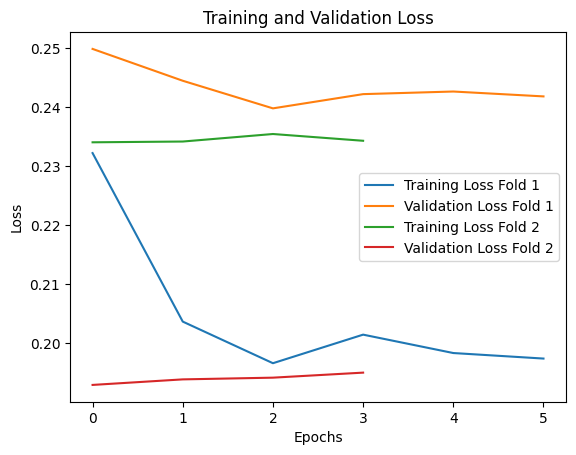

CPU times: user 606 ms, sys: 284 ms, total: 890 ms
Wall time: 594 ms


In [15]:
%%time

import matplotlib.pyplot as plt 
import seaborn as sns

for i, history in enumerate(history_list):
    plt.plot(history.history['loss'], label=f'Training Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {i+1}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [16]:
%%time

predictions.shape

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


(1975, 4)

In [17]:
%%time

# Convert logits to probabilities using softmax
probabilities = tf.nn.softmax(predictions, axis=1).numpy()

CPU times: user 3.36 ms, sys: 2.02 ms, total: 5.38 ms
Wall time: 19.4 ms


In [18]:
%%time

# Calculate the average sample weighted log loss
log_loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
average_log_loss = log_loss_fn(labels_encoded, probabilities).numpy()
print(f"Average Sample Weighted Log Loss: {average_log_loss}")

Average Sample Weighted Log Loss: 0.21134808659553528
CPU times: user 810 ms, sys: 22.6 ms, total: 833 ms
Wall time: 884 ms


In [19]:
%%time

# Convert probabilities to predicted class labels
predicted_labels = np.argmax(probabilities, axis=1)

CPU times: user 1.48 ms, sys: 6 µs, total: 1.49 ms
Wall time: 1.67 ms


In [20]:
%%time

# Convert numerical predicted labels back to original labels 
original_labels = label_encoder.inverse_transform(predicted_labels)

CPU times: user 841 µs, sys: 0 ns, total: 841 µs
Wall time: 1.6 ms


In [34]:
%%time

sample_submission = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv')

CPU times: user 3.31 ms, sys: 1 µs, total: 3.31 ms
Wall time: 5.82 ms


In [38]:
%%time

probabilities_subset = probabilities[:25]

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 16.7 µs


In [39]:
%%time

# Assign the three probability columns 
sample_submission['normal_mild'] = probabilities_subset[:, 0]
sample_submission['moderate'] = probabilities_subset[:, 1]
sample_submission['severe'] = probabilities_subset[:, 2]

CPU times: user 944 µs, sys: 0 ns, total: 944 µs
Wall time: 816 µs


In [44]:
%%time

# Save the submission file
corrected_submission_path = 'submission.csv'
sample_submission.to_csv(corrected_submission_path, index=False)

CPU times: user 2.95 ms, sys: 0 ns, total: 2.95 ms
Wall time: 2.34 ms


In [47]:
%%time 

sample_submission.head(25)

CPU times: user 253 µs, sys: 4 µs, total: 257 µs
Wall time: 272 µs


,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.000632,0.038282,0.949062
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.000632,0.038282,0.949062
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.000632,0.038282,0.949062
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.000632,0.038282,0.949062
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.000632,0.038282,0.949062
5,44036939_left_subarticular_stenosis_l1_l2,0.000632,0.038282,0.949062
6,44036939_left_subarticular_stenosis_l2_l3,0.000632,0.038282,0.949062
7,44036939_left_subarticular_stenosis_l3_l4,0.000632,0.038282,0.949062
8,44036939_left_subarticular_stenosis_l4_l5,0.000632,0.038282,0.949062
9,44036939_left_subarticular_stenosis_l5_s1,0.000632,0.038282,0.949062
